### Creating data points for testing Clustering 

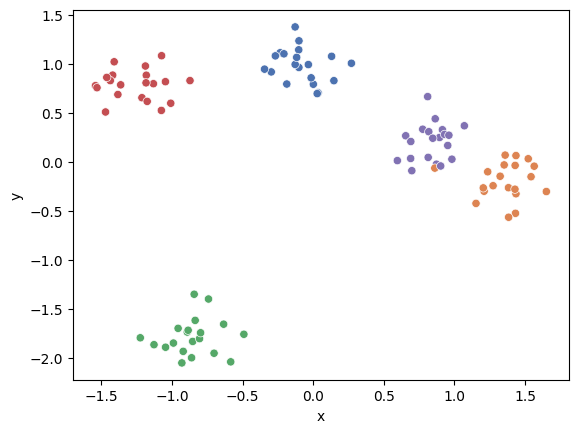

In [61]:
import seaborn as sns
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import random
centers = 5
X_train, true_labels = make_blobs(n_samples=100, centers=centers, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
sns.scatterplot(x=[X[0] for X in X_train],
                y=[X[1] for X in X_train],
                hue=true_labels,
                palette="deep",
                legend=None
                )
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Euclidean distance function to measure distances

In [62]:
def euclidean(point, data):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
    """
    return np.sqrt(np.sum((point - data)**2, axis=1))

### KMeans algorithm

In [63]:
class KMeans:
    def __init__(self, n_clusters=8, max_iter=300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
    def fit(self, X_train):
        # Initialize the centroids, using the "k-means++" method, where a random datapoint is selected as the first,
        # then the rest are initialized w/ probabilities proportional to their distances to the first
        # Pick a random point from train data for first centroid
        self.centroids = [random.choice(X_train)]
        for _ in range(self.n_clusters-1):
            # Calculate distances from points to the centroids
            dists = np.sum([euclidean(centroid, X_train) for centroid in self.centroids], axis=0)
            # Normalize the distances
            dists /= np.sum(dists)
            # Choose remaining points based on their distances
            new_centroid_idx, = np.random.choice(range(len(X_train)), size=1, p=dists)
            self.centroids += [X_train[new_centroid_idx]]
        # This initial method of randomly selecting centroid starts is less effective
        # min_, max_ = np.min(X_train, axis=0), np.max(X_train, axis=0)
        # self.centroids = [uniform(min_, max_) for _ in range(self.n_clusters)]
        # Iterate, adjusting centroids until converged or until passed max_iter
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            # Sort each datapoint, assigning to nearest centroid
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = euclidean(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)
            # Push current centroids to previous, reassign centroids as mean of the points belonging to them
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  # Catch any np.nans, resulting from a centroid having no points
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
    def evaluate(self, X):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx)
        return centroids, centroid_idxs

### Testing on generated datapoints

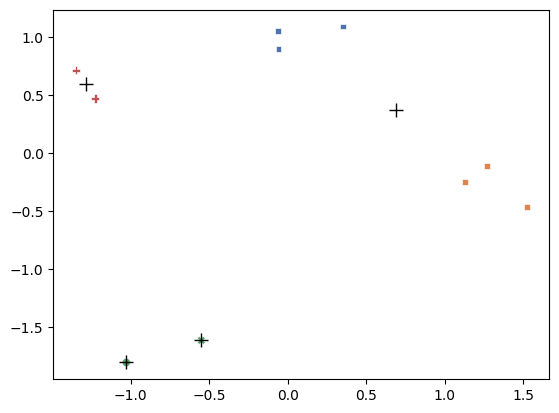

<class 'numpy.ndarray'>


In [64]:
# Create a dataset of 2D distributions
centers = 4
X_train, true_labels = make_blobs(n_samples=10, centers=centers, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
# Fit centroids to dataset
kmeans = KMeans(n_clusters=centers)
kmeans.fit(X_train)
# View results
class_centers, classification = kmeans.evaluate(X_train)
sns.scatterplot(x=[X[0] for X in X_train],
                y=[X[1] for X in X_train],
                hue=true_labels,
                style=classification,
                palette="deep",
                legend=None
                )
plt.plot([x for x, _ in kmeans.centroids],
         [y for _, y in kmeans.centroids],
         'k+',
         markersize=10,
         )
plt.show()
print(type(X_train))

In [65]:
df=pd.read_excel('Course Recommendation System(1-123).xlsx')
df=df.drop(['ID','Start time','Completion time','Email','Name','Name(not mandatory)\n' ], axis=1).fillna(0)
# df=df.iloc[:,0:2]
df

,Data Structures and Algorithms,Computer Architecture\n,Discrete Mathematics\n,Economics,Programming-2,Machine Learning\n,Mathematics For Machine Learning\n,Visual Recognition\n,Natural Language Processing\n,Reinforcement Learning,...,Digital CMOS VLSI Design,System design with FPGA,ASIC design,VLSI Architecture Design\n,High level synthesis and optimization of Digital Circuits,Digital Sociology,Privacy in the Digital Age,Technology Ethics and AI,Techno-economics of networks,The Web and the Mind
0,0.30,0.85,0.85,0.90,0.70,0.70,0.80,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.6,0.0,0.0,0.0
1,0.70,0.80,0.20,0.80,0.80,0.50,0.10,0.20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.0,0.0,0.0
2,0.70,0.00,1.00,1.00,1.00,1.00,1.00,0.80,0.9,1.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.4,0.0,0.0,0.0
3,0.65,0.70,0.20,0.75,0.75,0.75,0.75,0.75,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.80,0.0,0.0,0.8,0.0
4,0.70,0.60,0.20,0.00,0.80,0.50,0.60,0.40,0.4,0.2,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.80,0.10,0.90,0.05,0.60,1.00,1.00,1.00,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.6,0.7,0.0,0.2
119,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
120,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
121,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.50,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.00,0.0,1.0,1.0,0.0


In [66]:
df

,Data Structures and Algorithms,Computer Architecture\n,Discrete Mathematics\n,Economics,Programming-2,Machine Learning\n,Mathematics For Machine Learning\n,Visual Recognition\n,Natural Language Processing\n,Reinforcement Learning,...,Digital CMOS VLSI Design,System design with FPGA,ASIC design,VLSI Architecture Design\n,High level synthesis and optimization of Digital Circuits,Digital Sociology,Privacy in the Digital Age,Technology Ethics and AI,Techno-economics of networks,The Web and the Mind
0,0.30,0.85,0.85,0.90,0.70,0.70,0.80,0.00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.6,0.0,0.0,0.0
1,0.70,0.80,0.20,0.80,0.80,0.50,0.10,0.20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.0,0.0,0.0
2,0.70,0.00,1.00,1.00,1.00,1.00,1.00,0.80,0.9,1.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.4,0.0,0.0,0.0
3,0.65,0.70,0.20,0.75,0.75,0.75,0.75,0.75,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.80,0.0,0.0,0.8,0.0
4,0.70,0.60,0.20,0.00,0.80,0.50,0.60,0.40,0.4,0.2,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.80,0.10,0.90,0.05,0.60,1.00,1.00,1.00,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.05,0.6,0.7,0.0,0.2
119,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
120,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
121,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.50,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.00,0.0,1.0,1.0,0.0


In [67]:
x=[X[0] for X in df]
y=[X[1] for X in df]
print(len(x))
print(len(y))

25
25


In [68]:
df=df.to_numpy()

/tmp/ipykernel_728/2027844148.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=[X[0] for X in df],y=[X[1] for X in df],style=classification,palette="deep",legend=None)


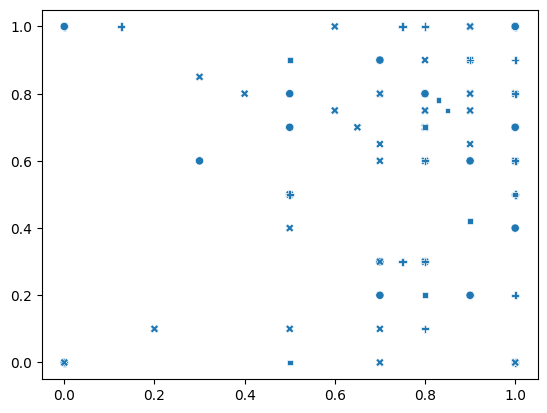

In [70]:

kmeans = KMeans(n_clusters=4)
kmeans.fit(df)
# View results
class_centers, classification = kmeans.evaluate(df)
sns.scatterplot(x=[X[0] for X in df],y=[X[1] for X in df],style=classification,palette="deep",legend=None)
# plt.plot([x for x, _ in kmeans.centroids],[y for _, y in kmeans.centroids],'k+',markersize=10)
plt.show()